# Analysis of ENSO predictability
##### Replicating the analysis in ENSO_predictability.ipynb for a box in the atlantic

In [1]:
%cd /OSM/CBR/OA_DCFP/work/squ027/doppyo/
! python setup.py install >/dev/null

/OSM/CBR/OA_DCFP/work/squ027/doppyo
zip_safe flag not set; analyzing archive contents...


In [2]:
import doppyo
import importlib
doppyo = importlib.reload(doppyo)

In [3]:
import re
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import xarray as xr

import cartopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Notebook specific -----
%matplotlib inline

In [4]:
import dask
import distributed
client = distributed.Client('tcp://oa-32-cdc.nexus.csiro.au:8786')
client

Client Scheduler: tcp://oa-32-cdc.nexus.csiro.au:8786 Dashboard: http://oa-32-cdc.nexus.csiro.au:8787/status,Cluster Workers: 16 Cores: 128 Memory: 1024.00 GB


In [5]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/papers/Risbey_Nature/'

# A note about bias corrections
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02.
The mutual span of these datasets is **1982-01 -> 2018-02**

We analyse both uncorrected and bias corrected data. The notation used is as follows:
1. **nbc** : no bias correction; anomalies are computed relative to the 30-year running mean of the observed values - see Kirtman *et al.* 2014. and http://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_change.shtml
2. **sbc** : simple bias correction; anomalies are computed relative to the lead_time=0 model climatology over the hindcast / forecast period (1981-01 -> 2018-02).
3. **fbc** : full bias correction; the mean and standard deviation over the hindcast / forecast period (1981-01 -> 2018-02) are adjusted to match the observed values over the climatological period (1971-01 -> 2000-12), as a function of month and lead time.

Other important notation:
1. **f1** : from CAFE-f1 hindcasts
2. **cm3** : from Can CM3 hindcasts / forecasts
3. **cm4** : from Can CM4 hindcasts / forecasts
4. **had** : from Hadley ISST observations
5. **raw** : full-field and uncorrected
6. **ts** : time series data (rather than init_date/lead_time bundle)
7. **clim** : climatology, defined over periods described above

# Another note
All data is interpolated onto the Hadley ISST grid

# Load the raw temperature data, compute anomalies and nino3.4

In [6]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [7]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [8]:
def running_anomaly(fcst, obsv_ts, span=30):
    """ 
        Returns anomalies computed about running climatology of specified span 
        The input `fcst` should contain only a single init_date, e.g. as obtained from da.groupby('init_date')
        
        If the running climatological period extends beyond the observed period, the final `span` years are used
    """
    
    year = fcst.init_date.dt.year.values
    month = fcst.init_date.dt.month.values

    clim_start = str(year-int(span/2))+'-'+str(month).zfill(2)
    clim_end = str(year+int(span/2))+'-'+str(month).zfill(2)

    if np.datetime64(clim_end) > obsv_ts.time[-1].values:
        clim_start = str(obsv_ts.time[-1].dt.year.values-int(span))+'-'+str(obsv_ts.time[-1].dt.month.values).zfill(2)
        clim_end = obsv_ts.time[-1].values

    clim = obsv_ts.sel(time=slice(clim_start, clim_end)).groupby('time.month').mean('time')

    return lambda_anomalize(fcst, clim)

### Raw Hadley ISST data

In [9]:
had_sst_raw_ts = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.had_sst_raw_ts.nc')['sst']
had_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.had_atlntc_nbc.nc')['sst']
had_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.had_atlntc_sbc.nc')['sst']

### Raw CAFE-f1 data (not yet available)

##### nbc CAFE-f1 anomalies

##### sbc CAFE-f1 anomalies

##### fbc CAFE-f1 anomalies

##### Delete raw CAFE-f1

### Raw COLA-RSMAS-CCSM4 data

In [10]:
cola_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cola_atlntc_nbc.nc')['sst']
cola_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cola_atlntc_sbc.nc')['sst']

### Raw GFDL-CM2p1-aer04 data

In [11]:
aer04_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.aer04_atlntc_nbc.nc')['sst']
aer04_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.aer04_atlntc_sbc.nc')['sst']

### Raw GFDL-CM2p5-FLOR-A06 data

In [12]:
florA_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.florA_atlntc_nbc.nc')['sst']
florA_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.florA_atlntc_sbc.nc')['sst']

### Raw GFDL-CM2p5-FLOR-B01 data

In [13]:
florB_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.florB_atlntc_nbc.nc')['sst']
florB_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.florB_atlntc_sbc.nc')['sst']

### Raw CMC CanCM3 data

In [14]:
cm3_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cm3_atlntc_nbc.nc')['sst']
cm3_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cm3_atlntc_sbc.nc')['sst']

### Raw CMC CanCM4 data

In [15]:
cm4_atlntc_nbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cm4_atlntc_nbc.nc')['sst']
cm4_atlntc_sbc = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.cm4_atlntc_sbc.nc')['sst']

# ATLANTIC BOX
___________________________________________________________________________

# Select which forecasts and observations to use

In [16]:
fcst_use = xr.concat([cola_atlntc_sbc, aer04_atlntc_sbc, florA_atlntc_sbc, florB_atlntc_sbc, cm3_atlntc_sbc, cm4_atlntc_sbc], dim='ensemble')
fcst_use['ensemble'] = np.arange(1,len(fcst_use['ensemble'])+1)
# fcst_use = cola_atlntc_sbc
obsv_use = had_atlntc_sbc

obsv_use_ts = obsv_use.isel(lead_time=0, drop=True)

# Observed auto-correlation function

In [17]:
def date_to_monthyear(da):
    """ Split time dimension into month and year dimensions """
    
    da = da.copy()
    da['month'] = da.init_date.dt.month
    da['year'] = da.init_date.dt.year
    
    return da.set_index(init_date=['year', 'month']).unstack('init_date')

In [18]:
lags = np.arange(0,12)
obsv_use_my = date_to_monthyear(obsv_use_ts)

ac_obsv = []
for lag in lags:
    obsv_use_shift = obsv_use_ts.shift(init_date=-lag)
    ac_obsv.append(doppyo.skill.Pearson_corrcoeff(date_to_monthyear(obsv_use_ts), 
                                                  date_to_monthyear(obsv_use_shift), over_dims='year'))
ac_obsv = xr.concat(ac_obsv, dim='lag')
ac_obsv = ac_obsv.rename({'lag':'lead_time'})
ac_obsv['lead_time'] = np.arange(12)
ac_obsv.lead_time.attrs['units'] = 'MS'

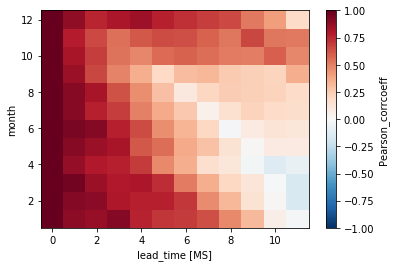

In [19]:
ac_obsv.T.plot();
plt.savefig(saveloc + 'HadISST_atlantic_autocorrelation.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'HadISST_atlantic_autocorrelation.png', dpi=600, format='png', bbox_inches='tight')

# Statistical forecast decaying from initial condition at rate determined by autcorrelation function

In [20]:
stat_use = (doppyo.utils.repeat_datapoint(obsv_use, 'lead_time', 0).groupby('init_date.month') * ac_obsv)

# Get ENSO events

In [21]:
from scipy.ndimage.measurements import label

In [22]:
threshold = 0.17
elnino = obsv_use_ts.rolling(init_date=3, center=True).mean() > threshold
elnino.values = label(1*elnino)[0]
lanina = obsv_use_ts.rolling(init_date=3, center=True).mean() < -threshold
lanina.values = label(1*lanina)[0]

In [23]:
zero_month = 4
peak_month = 12

elnino_max = 0 * elnino.copy()
elnino_lanina_max = 0 * elnino.copy()
elnino_elneut_max = 0 * elnino.copy()
elnino_laneut_max = 0 * elnino.copy()
elnino_neutral_max = 0 * elnino.copy()
elnino_elnino_max = 0 * elnino.copy()
elnino_prezero = 0 * elnino.copy()
elnino_postzero = 0 * elnino.copy()
elnino_lanina_postzero = 0 * elnino.copy()
for i in range(max(elnino.values)):
    current_elnino = obsv_use_ts.where(elnino==(i+1))
    current_peak = elnino.where(current_elnino==current_elnino.max()).fillna(0)
    max_date = current_peak.where(current_peak != 0, drop=True).init_date
    if (obsv_use_ts.sel(init_date=slice(str(max_date[0].values), str(doppyo.sugar.year_delta(max_date.item(), 1)))) < -threshold).sum('init_date') > 1:
        elnino_lanina_max = elnino_lanina_max + current_peak
        elnino_lanina_max.values = label(elnino_lanina_max.values)[0]
        elnino_laneut_max = elnino_laneut_max + current_peak
        elnino_laneut_max.values = label(elnino_laneut_max.values)[0]
    elif ((elnino.sel(init_date=str(doppyo.sugar.year_delta(max_date.item(), 1)), method='nearest') == 0) &
          (lanina.sel(init_date=str(doppyo.sugar.year_delta(max_date.item(), 1)), method='nearest') == 0)):
        elnino_elneut_max = elnino_elneut_max + current_peak
        elnino_elneut_max.values = label(elnino_elneut_max.values)[0]
        elnino_laneut_max = elnino_laneut_max + current_peak
        elnino_laneut_max.values = label(elnino_laneut_max.values)[0]
        elnino_neutral_max = elnino_neutral_max + current_peak
        elnino_neutral_max.values = label(elnino_neutral_max.values)[0]
    else:
        elnino_elneut_max = elnino_elneut_max + current_peak
        elnino_elneut_max.values = label(elnino_elneut_max.values)[0]
        elnino_elnino_max = elnino_elnino_max + current_peak
        elnino_elnino_max.values = label(elnino_elnino_max.values)[0]
    elnino_max = elnino_max + current_peak
    max_month = max_date.dt.month.item()
    zero_shift = max_month - zero_month
    if zero_shift < 0:
        zero_shift = zero_shift + 12
    elnino_prezero = elnino_prezero + current_peak.shift(init_date=-zero_shift).fillna(0)
    elnino_prezero.values = label(elnino_prezero.values)[0]
    elnino_postzero = elnino_postzero + current_peak.shift(init_date=12-zero_shift).fillna(0)
    elnino_postzero.values = label(elnino_postzero.values)[0]
    if (obsv_use_ts.sel(init_date=slice(str(max_date[0].values), str(doppyo.sugar.year_delta(max_date.item(), 1)))) < -threshold).sum('init_date') > 1:
        elnino_lanina_postzero = elnino_lanina_postzero + current_peak.shift(init_date=12-zero_shift).fillna(0)
        elnino_lanina_postzero.values = label(elnino_lanina_postzero.values)[0]
    
lanina_min = 0 * lanina.copy()
lanina_elnino_min = 0 * lanina.copy()
lanina_laneut_min = 0 * elnino.copy()
lanina_elneut_min = 0 * elnino.copy()
lanina_neutral_min = 0 * lanina.copy()
lanina_lanina_min = 0 * lanina.copy()
lanina_prezero = 0 * lanina.copy()
lanina_postzero = 0 * lanina.copy()
lanina_elnino_postzero = 0 * elnino.copy()
for i in range(max(lanina.values)):
    current_lanina = obsv_use_ts.where(lanina==(i+1))
    current_trough = lanina.where(current_lanina==current_lanina.min()).fillna(0)
    min_date = current_trough.where(current_trough != 0, drop=True).init_date
    if (obsv_use_ts.sel(init_date=slice(str(min_date[0].values), str(doppyo.sugar.year_delta(min_date.item(), 1)))) > threshold).sum('init_date') > 1:
        lanina_elnino_min = lanina_elnino_min + current_trough
        lanina_elnino_min.values = label(lanina_elnino_min.values)[0]
        lanina_elneut_min = lanina_elneut_min + current_trough
        lanina_elneut_min.values = label(lanina_elneut_min.values)[0]
    elif ((elnino.sel(init_date=str(doppyo.sugar.year_delta(min_date.item(), 1)), method='nearest') == 0) &
          (lanina.sel(init_date=str(doppyo.sugar.year_delta(min_date.item(), 1)), method='nearest') == 0)):
        lanina_laneut_min = lanina_laneut_min + current_trough
        lanina_laneut_min.values = label(lanina_laneut_min.values)[0]
        lanina_elneut_min = lanina_elneut_min + current_trough
        lanina_elneut_min.values = label(lanina_elneut_min.values)[0]
        lanina_neutral_min = lanina_neutral_min + current_trough
        lanina_neutral_min.values = label(lanina_neutral_min.values)[0]
    else:
        lanina_laneut_min = lanina_laneut_min + current_trough
        lanina_laneut_min.values = label(lanina_laneut_min.values)[0]
        lanina_lanina_min = lanina_lanina_min + current_trough
        lanina_lanina_min.values = label(lanina_lanina_min.values)[0]
    lanina_min = lanina_min + current_trough
    min_month = min_date.dt.month.item()
    zero_shift = min_month - zero_month
    if zero_shift < 0:
        zero_shift = zero_shift + 12
    lanina_prezero = lanina_prezero + current_trough.shift(init_date=-zero_shift).fillna(0)
    lanina_prezero.values = label(lanina_prezero.values)[0]
    lanina_postzero = lanina_postzero + current_trough.shift(init_date=12-zero_shift).fillna(0)
    lanina_postzero.values = label(lanina_postzero.values)[0]
    if (obsv_use_ts.sel(init_date=slice(str(min_date[0].values), str(doppyo.sugar.year_delta(min_date.item(), 1)))) > threshold).sum('init_date') > 1:
        lanina_elnino_postzero = lanina_elnino_postzero + current_trough.shift(init_date=12-zero_shift).fillna(0)
        lanina_elnino_postzero.values = label(lanina_elnino_postzero.values)[0]

In [24]:
from matplotlib.collections import LineCollection

def plot_fcst(t, x, ax=None, cmap='jet', **kwargs):
    # Convert dates to numbers first ---- 
    inxval = matplotlib.dates.date2num(t.to_index().to_pydatetime())
    points = np.array([inxval, x.values]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, **kwargs)
    lc.set_array(inxval)
    
    monthFmt = matplotlib.dates.DateFormatter("%Y")
    if ax is None:
        ax = plt.gca()
        
    ax.add_collection(lc)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.autoscale_view()
    ax.xaxis_date()

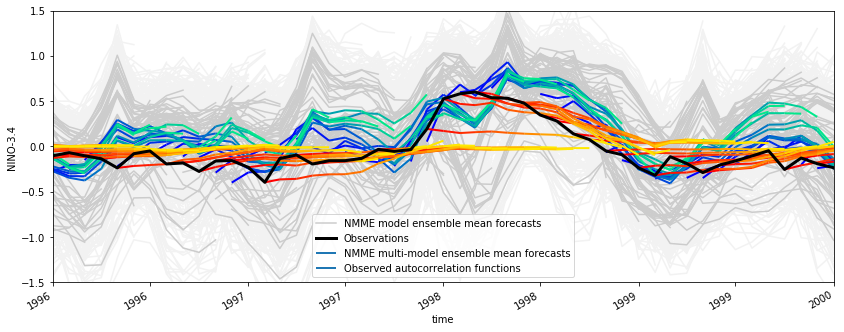

In [25]:
figure = plt.figure(figsize=(14,5))

fcst_dates = pd.date_range(start='1995-01', end='2000-01', freq='MS')[::-1]
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).mean('ensemble'), cmap='winter', **{'linewidth':2,'label':'NMME multi-model ensemble mean forecasts'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).mean('ensemble'), cmap='winter', **{'linewidth':2,'label':'_nolegend_'})
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)), cmap='autumn', **{'linewidth':2,'label':'Observed autocorrelation functions'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)), cmap='autumn', **{'linewidth':2,'label':'_nolegend_'})
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_atlntc_sbc.sel(init_date=date)).time.values,
                  doppyo.utils.leadtime_to_datetime(cola_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='NMME model ensemble mean forecasts')
    else:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_atlntc_sbc.sel(init_date=date)).time.values,
                  doppyo.utils.leadtime_to_datetime(cola_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(aer04_atlntc_sbc.sel(init_date=date)).time.values,
              doppyo.utils.leadtime_to_datetime(aer04_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florA_atlntc_sbc.sel(init_date=date)).time.values,
              doppyo.utils.leadtime_to_datetime(florA_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florB_atlntc_sbc.sel(init_date=date)).time.values,
              doppyo.utils.leadtime_to_datetime(florB_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm3_atlntc_sbc.sel(init_date=date)).time.values,
              doppyo.utils.leadtime_to_datetime(cm3_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_atlntc_sbc.sel(init_date=date)).time.values,
              doppyo.utils.leadtime_to_datetime(cm4_atlntc_sbc.sel(init_date=date)).mean('ensemble'), color=(0.8,0.8,0.8), zorder=1, label='_nolegend_')

for idx, date in enumerate(fcst_dates):
    plt.plot(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)), color=(0.95,0.95,0.95), zorder=0, label='_nolegend_')

obsv_use_ts.plot(color='k', linestyle='-', linewidth=3, label='Observations')

plt.xlim('1996','2000')
plt.ylim(-1.5,1.5);
plt.xlabel('time');
plt.ylabel('NINO-3.4');
plt.legend()
plt.title('');

plt.savefig(saveloc + 'atlantic_timeseries_lHeureux.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'atlantic_timeseries_lHeureux.png', dpi=600, format='png', bbox_inches='tight')

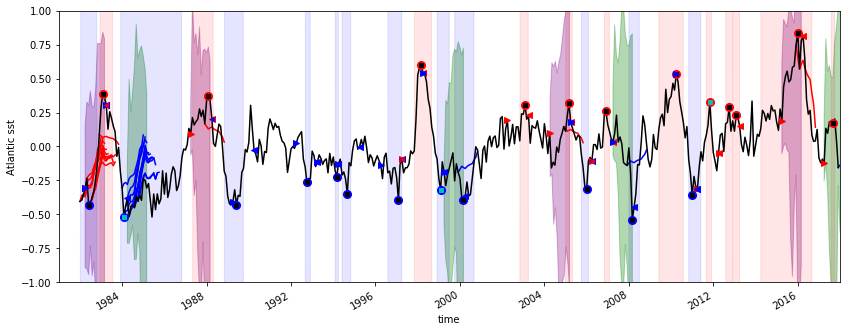

In [26]:
figure = plt.figure(figsize=(14,5))
fcst_dates = ['1982-04-01', '1987-04-01', '2004-04-01', '2015-04-01']
for date in fcst_dates:
    plt.fill_between(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time.values,
                     doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date).max('ensemble')),
                     doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date).min('ensemble')), color='purple', alpha=0.3)
fcst_dates = ['1984-04-01', '1999-04-01', '2007-04-01', '2017-04-01']
for date in fcst_dates:
    plt.fill_between(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time.values,
                     doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date).max('ensemble')),
                     doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date).min('ensemble')), color='green', alpha=0.3)
    
fcst_dates = ['1982-01-01','1982-02-01','1982-03-01','1982-04-01','1982-05-01','1982-06-01','1982-07-01',
              '1982-08-01','1982-09-01','1982-10-01','1982-11-01','1982-12-01', '1987-12-01', '2004-12-01', '2015-12-01']
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)), color='red')
fcst_dates = ['1984-01-01','1984-02-01','1984-03-01','1984-04-01','1984-05-01','1984-06-01','1984-07-01',
              '1984-08-01','1984-09-01','1984-10-01','1984-11-01', '1999-12-01', '2007-12-01', '2017-12-01']
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(stat_use.sel(init_date=date)), color='blue')
    
obsv_use_ts.plot(color='k')
plt.fill_between(elnino.init_date.values, -5, (10*elnino-3.5), color='red', alpha=0.1, edgecolor=None)
obsv_use_ts.where(elnino_max).plot(marker='o', color='r', markersize=8)
obsv_use_ts.where(elnino_lanina_max).plot(marker='o', color='b', markersize=4)
obsv_use_ts.where(elnino_laneut_max).plot(marker='s', color='k', markersize=4)
obsv_use_ts.where(elnino_elnino_max).plot(marker='s', color='c', markersize=4)
obsv_use_ts.where(elnino_prezero).plot(marker='>', color='r')
obsv_use_ts.where(elnino_postzero).plot(marker='<', color='r')
obsv_use_ts.where(elnino_lanina_postzero).plot(marker='<', color='b', markersize=4)
plt.fill_between(lanina.init_date.values, -5, (10*lanina-3.5), color='blue', alpha=0.1, edgecolor=None)
obsv_use_ts.where(lanina_min).plot(marker='o', color='b', markersize=8)
obsv_use_ts.where(lanina_elnino_min).plot(marker='o', color='r', markersize=4)
obsv_use_ts.where(lanina_elneut_min).plot(marker='s', color='k', markersize=4)
obsv_use_ts.where(lanina_lanina_min).plot(marker='s', color='c', markersize=4)
obsv_use_ts.where(lanina_prezero).plot(marker='>', color='b')
obsv_use_ts.where(lanina_postzero).plot(marker='<', color='b')
obsv_use_ts.where(lanina_elnino_postzero).plot(marker='<', color='r', markersize=4)

fcst_use.sel(init_date='1982-04-01')

plt.xlim('1981','2018')
plt.ylim(-1,1);
plt.xlabel('time');
plt.ylabel('Atlantic sst');
plt.title('');

plt.savefig(saveloc + 'atlantic_timeseries.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'atlantic_timeseries.png', dpi=600, format='png', bbox_inches='tight')

# Richard-style acc and rpss

In [27]:
def init_date_to_target_date(da, init_date_coord='init_month', lead_time_coord='lead_time'):
    """ 
    Convert from initial date format to target date format 
    Note : this function only works when initial date and lead time are matching frequencies
    """
    new = []
    for lead in da[lead_time_coord]:
        rolled = da.sel({lead_time_coord : lead.values}).roll(**{init_date_coord : lead.values})
        rolled[init_date_coord].values = da[init_date_coord].values
        new.append(rolled)

    return xr.concat(new, dim=lead_time_coord).rename({init_date_coord : init_date_coord.replace('init','target')})

#### Ranked probability score

In [28]:
bins=np.linspace(-1.5,1.5,5)

atlntc_rps = doppyo.skill.rps(fcst_use, obsv_use, bins=bins, over_dims=None)

In [29]:
clim = obsv_use_ts.sel(init_date=slice('1971','2000'))

bin_edges = doppyo.utils.get_bin_edges(bins)
prob_in_bin = []
for e in range(len(bin_edges)-1):
    prob_in_bin.append(((clim >= bin_edges[e]) & (clim < bin_edges[e+1])).groupby('init_date.month').mean('init_date', skipna=True) / (bin_edges[e+1] - bin_edges[e]))

pdf_cmp = xr.concat(prob_in_bin, dim='bins')
pdf_cmp['bins'] = bins

cdf_cmp = doppyo.utils.integrate(pdf_cmp, over_dim='bins', method='rect', cumulative=True)
cdf_cmp = (0 * obsv_use).groupby('init_date').apply(lambda_anomalize, clim=-cdf_cmp)

cdf_ref = doppyo.utils.cdf(obsv_use, bin_edges=bin_edges, over_dims=None)

atlntc_rpsc = doppyo.utils.integrate((cdf_cmp - cdf_ref) ** 2, over_dim='bins')

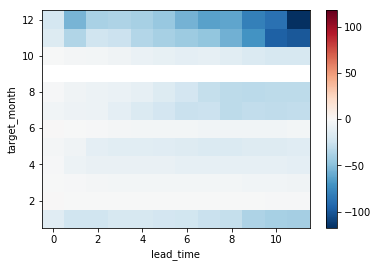

In [30]:
atlntc_rpss = 1 - atlntc_rps / atlntc_rpsc
init_date_to_target_date(date_to_monthyear(atlntc_rpss).mean('year'), init_date_coord='month').T.plot()
plt.ylabel('target_month')
plt.savefig(saveloc + 'RPSS_atlantic_target_month.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'RPSS_atlantic_target_month.png', dpi=600, format='png', bbox_inches='tight')

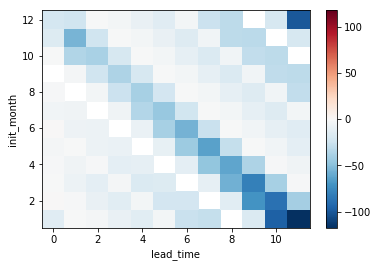

In [31]:
date_to_monthyear(atlntc_rpss).mean('year').T.plot()
plt.ylabel('init_month')
plt.savefig(saveloc + 'RPSS_atlantic_init_month.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'RPSS_atlantic_init_month.png', dpi=600, format='png', bbox_inches='tight')

#### Anomaly cross correlation

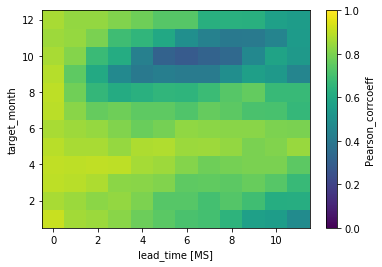

In [88]:
init_date_to_target_date(doppyo.skill.Pearson_corrcoeff(date_to_monthyear(fcst_use.mean('ensemble')), date_to_monthyear(obsv_use), over_dims='year'), init_date_coord='month').T.plot(vmin=0, vmax=1)
plt.ylabel('target_month')
plt.savefig(saveloc + 'ACC_atlantic_target_month.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'ACC_atlantic_target_month.png', dpi=600, format='png', bbox_inches='tight')

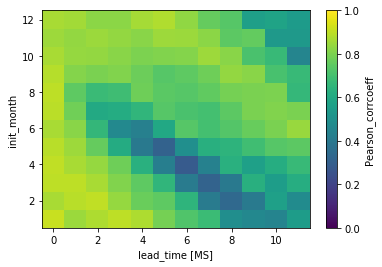

In [90]:
doppyo.skill.Pearson_corrcoeff(date_to_monthyear(fcst_use.mean('ensemble')), date_to_monthyear(obsv_use), over_dims='year').T.plot(vmin=0, vmax=1)
plt.ylabel('init_month')
plt.savefig(saveloc + 'ACC_atlantic_init_month.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'ACC_atlantic_init_month.png', dpi=600, format='png', bbox_inches='tight')

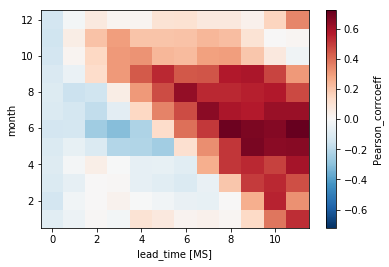

In [92]:
(doppyo.skill.Pearson_corrcoeff(date_to_monthyear(fcst_use.mean('ensemble')), date_to_monthyear(obsv_use), over_dims='year') - doppyo.skill.Pearson_corrcoeff(date_to_monthyear(stat_use), date_to_monthyear(obsv_use), over_dims='year')).T.plot()

# El Nino onset
1. **baseline** - assess all forecasts starting in `zero_month`
2. **onset, no El Nino** - assess only forecasts starting in `zero_month` for which no El Nino occurred
3. **onset, El Nino** - assess only forecasts starting in `zero_month` for which El Nino occurred

#### Root mean squared error

In [34]:
elnino_onset_baseline_rms = doppyo.skill.rms_error(fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('ensemble'),
                                                   obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])

elnino_onset_noevent_rms = doppyo.skill.rms_error(fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True).mean('ensemble'),
                                                obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), over_dims=['init_date'])

elnino_onset_event_rms = doppyo.skill.rms_error(fcst_use.where(elnino_prezero, drop=True).mean('ensemble'),
                                                 obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

# Statistical forecast -----
elnino_onset_baseline_rms_stat = doppyo.skill.rms_error(stat_use.where(stat_use.init_date.dt.month == zero_month, drop=True),
                                                        obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])

elnino_onset_noevent_rms_stat = doppyo.skill.rms_error(stat_use.where((stat_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True),
                                                       obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), over_dims=['init_date'])

elnino_onset_event_rms_stat = doppyo.skill.rms_error(stat_use.where(elnino_prezero, drop=True),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

# Add indiviual models ---
elnino_onset_event_rms_cola = doppyo.skill.rms_error(cola_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_rms_aer04 = doppyo.skill.rms_error(aer04_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_rms_florA = doppyo.skill.rms_error(florA_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_rms_florB = doppyo.skill.rms_error(florB_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_rms_cm3 = doppyo.skill.rms_error(cm3_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_rms_cm4 = doppyo.skill.rms_error(cm4_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [35]:
n_ens = 10
n_bootstrap=100

In [36]:
def random_ensemble(da, j):
    random_ensembles = random.sample(list(da.ensemble.values), k=j)
    da_out = da.sel(ensemble = random_ensembles)
    da_out['ensemble'] = np.arange(1,len(da_out['ensemble'])+1)
    return da_out

In [37]:
def bootstrap_metric(metric, da_cmp, n_ens=20, n_bootstrap=100, avg_ensemble=False, **kwargs):
    metric_bootstrap = []
    for n in range(n_bootstrap):
        da_test = random_ensemble(da_cmp, n_ens)
        if avg_ensemble:
            da_test = da_test.mean('ensemble')
        metric_bootstrap.append(metric(da_test, **kwargs))
    return xr.concat(metric_bootstrap, dim='bootstrap sample')

In [38]:
elnino_onset_baseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True),
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])
elnino_onset_baseline_rms_bs = xr.concat([elnino_onset_baseline_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_baseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_noevent_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), 
                                               over_dims=['init_date'])
elnino_onset_noevent_rms_bs = xr.concat([elnino_onset_noevent_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_noevent_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_event_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(elnino_prezero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(elnino_prezero, drop=True), 
                                             over_dims=['init_date'])
elnino_onset_event_rms_bs = xr.concat([elnino_onset_event_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_event_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ranked probability skill score

##### Forecasts

In [39]:
bins=np.linspace(-1.5,1.5,5)

elnino_onset_rps = doppyo.skill.rps(fcst_use, obsv_use, bins=bins, over_dims=None)

elnino_onset_baseline_rps = elnino_onset_rps.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('init_date')

elnino_onset_noevent_rps = elnino_onset_rps.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True).mean('init_date')

elnino_onset_event_rps = elnino_onset_rps.where(elnino_prezero, drop=True).mean('init_date')

# Add indiviual models ---
elnino_onset_event_rps_cola = doppyo.skill.rps(cola_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

elnino_onset_event_rps_aer04 = doppyo.skill.rps(aer04_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

elnino_onset_event_rps_florA = doppyo.skill.rps(florA_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

elnino_onset_event_rps_florB = doppyo.skill.rps(florB_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

elnino_onset_event_rps_cm3 = doppyo.skill.rps(cm3_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

elnino_onset_event_rps_cm4 = doppyo.skill.rps(cm4_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(elnino_prezero, drop=True).mean('init_date')

##### Climatological weight

In [40]:
clim = obsv_use_ts.sel(init_date=slice('1971','2000'))

bin_edges = doppyo.utils.get_bin_edges(bins)
prob_in_bin = []
for e in range(len(bin_edges)-1):
    prob_in_bin.append(((clim >= bin_edges[e]) & (clim < bin_edges[e+1])).groupby('init_date.month').mean('init_date', skipna=True) / (bin_edges[e+1] - bin_edges[e]))

pdf_cmp = xr.concat(prob_in_bin, dim='bins')
pdf_cmp['bins'] = bins

cdf_cmp = doppyo.utils.integrate(pdf_cmp, over_dim='bins', method='rect', cumulative=True)
cdf_cmp = (0 * obsv_use).groupby('init_date').apply(lambda_anomalize, clim=-cdf_cmp)

cdf_ref = doppyo.utils.cdf(obsv_use, bin_edges=bin_edges, over_dims=None)

elnino_onset_rpsc = doppyo.utils.integrate((cdf_cmp - cdf_ref) ** 2, over_dim='bins')

elnino_onset_baseline_rpsc = doppyo.utils.integrate((cdf_cmp.where(fcst_use.init_date.dt.month == zero_month, drop=True) - 
                                                     cdf_ref.where(obsv_use.init_date.dt.month == zero_month, drop=True)) ** 2, over_dim='bins').mean('init_date')

In [41]:
elnino_onset_baseline_rpss = 1 - elnino_onset_baseline_rps / elnino_onset_baseline_rpsc

elnino_onset_noevent_rpss = 1 - elnino_onset_noevent_rps / elnino_onset_baseline_rpsc

elnino_onset_event_rpss = 1 - elnino_onset_event_rps / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_cola = 1 - elnino_onset_event_rps_cola / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_aer04 = 1 - elnino_onset_event_rps_aer04 / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_florA = 1 - elnino_onset_event_rps_florA / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_florB = 1 - elnino_onset_event_rps_florB / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_cm3 = 1 - elnino_onset_event_rps_cm3 / elnino_onset_baseline_rpsc

elnino_onset_event_rpss_cm4 = 1 - elnino_onset_event_rps_cm4 / elnino_onset_baseline_rpsc

##### Bootstrapped error bars

In [42]:
elnino_onset_rps_bs = bootstrap_metric(doppyo.skill.rps, fcst_use, n_ens=n_ens, n_bootstrap=n_bootstrap, da_ref=obsv_use, bins=bins, over_dims=None)

elnino_onset_baseline_rpss_bs = 1 - elnino_onset_rps_bs.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('init_date') / elnino_onset_baseline_rpsc
elnino_onset_baseline_rpss_bs = xr.concat([elnino_onset_baseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_baseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_noevent_rpss_bs = 1 - elnino_onset_rps_bs.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True).mean('init_date') / elnino_onset_baseline_rpsc
elnino_onset_noevent_rpss_bs = xr.concat([elnino_onset_noevent_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_noevent_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_event_rpss_bs = 1 - elnino_onset_rps_bs.where(elnino_prezero, drop=True).mean('init_date') / elnino_onset_baseline_rpsc
elnino_onset_event_rpss_bs = xr.concat([elnino_onset_event_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_event_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Anomaly cross correlation

In [43]:
elnino_onset_baseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('ensemble'),
                                                           obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')

elnino_onset_noevent_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True).mean('ensemble'),
                                                          obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), over_dims='init_date')

elnino_onset_event_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(elnino_prezero, drop=True).mean('ensemble'),
                                                        obsv_use.where(elnino_prezero, drop=True), over_dims='init_date')

# Statistical forecasts -----
elnino_onset_baseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(stat_use.init_date.dt.month == zero_month, drop=True),
                                                           obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')

elnino_onset_noevent_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where((stat_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True),
                                                          obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), over_dims='init_date')

elnino_onset_event_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(elnino_prezero, drop=True),
                                                             obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

# Add indiviual models ---
elnino_onset_event_acc_cola = doppyo.skill.Pearson_corrcoeff(cola_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                             obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_acc_aer04 = doppyo.skill.Pearson_corrcoeff(aer04_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_acc_florA = doppyo.skill.Pearson_corrcoeff(florA_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_acc_florB = doppyo.skill.Pearson_corrcoeff(florB_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_acc_cm3 = doppyo.skill.Pearson_corrcoeff(cm3_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                            obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

elnino_onset_event_acc_cm4 = doppyo.skill.Pearson_corrcoeff(cm4_atlntc_sbc.where(elnino_prezero, drop=True).mean('ensemble'),
                                                            obsv_use.where(elnino_prezero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [44]:
elnino_onset_baseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True), 
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')
elnino_onset_baseline_acc_bs = xr.concat([elnino_onset_baseline_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_baseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_noevent_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                               da_ref=obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), 
                                               over_dims='init_date')
elnino_onset_noevent_acc_bs = xr.concat([elnino_onset_noevent_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_noevent_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_onset_event_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(elnino_prezero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                             da_ref=obsv_use.where(elnino_prezero, drop=True), over_dims='init_date')
elnino_onset_event_acc_bs = xr.concat([elnino_onset_event_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_event_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ensemble spread

In [45]:
elnino_onset_baseline_spread = fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).std('ensemble').mean('init_date')

elnino_onset_noevent_spread = fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread = fcst_use.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

# Add indiviual models ---
elnino_onset_event_spread_cola = cola_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread_aer04 = aer04_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread_florA = florA_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread_florB = florB_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread_cm3 = cm3_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

elnino_onset_event_spread_cm4 = cm4_atlntc_sbc.where(elnino_prezero, drop=True).std('ensemble').mean('init_date')

##### Bootstrapped error bars

In [46]:
def ensemble_std(da):
    return da.std('ensemble')

In [47]:
elnino_onset_baseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True), 
                                                   n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_onset_baseline_spread_bs = xr.concat([elnino_onset_baseline_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_baseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

elnino_onset_noevent_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (elnino_prezero == 0), drop=True), 
                                                  n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_onset_noevent_spread_bs = xr.concat([elnino_onset_noevent_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_noevent_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

elnino_onset_event_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(elnino_prezero, drop=True), 
                                                n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_onset_event_spread_bs = xr.concat([elnino_onset_event_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_onset_event_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

#### Departure time

##### Falls within n ensemble standard deviations of the ensemble mean

In [48]:
n = 2
ensemble_bounds = (fcst_use.mean('ensemble') - n*fcst_use.std('ensemble'), fcst_use.mean('ensemble') + n*fcst_use.std('ensemble'))

##### Falls within ensemble spread

In [49]:
ensemble_bounds = (fcst_use.min(dim='ensemble'), fcst_use.max(dim='ensemble'))

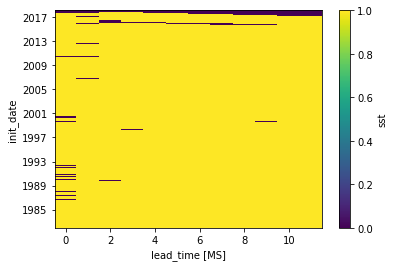

In [50]:
((obsv_use > ensemble_bounds[0]) & (obsv_use < ensemble_bounds[1])).plot()
plt.savefig(saveloc + 'Departure_time_atlantic.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'Departure_time_atlantic.png', dpi=600, format='png', bbox_inches='tight')

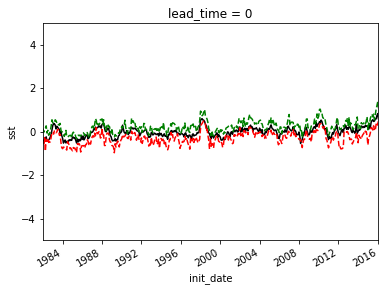

In [51]:
lead=0
obsv_use.isel(lead_time=0).shift(init_date=-lead).plot(color='k')
ensemble_bounds[0].isel(lead_time=lead).plot(color='r', linestyle='--')
ensemble_bounds[1].isel(lead_time=lead).plot(color='g', linestyle='--')
plt.xlim('1982','2016')
plt.ylim(-5,5);

# La Nina onset
1. **baseline** - assess all forecasts starting in `zero_month`
2. **onset, no La Nina** - assess only forecasts starting in `zero_month` for which no La Nina occurred
3. **onset, La Nina** - assess only forecasts starting in `zero_month` for which La Nina occurred

#### Root mean squared error

In [52]:
lanina_onset_baseline_rms = doppyo.skill.rms_error(fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('ensemble'),
                                                   obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])

lanina_onset_noevent_rms = doppyo.skill.rms_error(fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True).mean('ensemble'),
                                                obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), over_dims=['init_date'])

lanina_onset_event_rms = doppyo.skill.rms_error(fcst_use.where(lanina_prezero, drop=True).mean('ensemble'),
                                                obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

# Statistical forecasts ---
lanina_onset_baseline_rms_stat = doppyo.skill.rms_error(stat_use.where(stat_use.init_date.dt.month == zero_month, drop=True),
                                                   obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])

lanina_onset_noevent_rms_stat = doppyo.skill.rms_error(stat_use.where((stat_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True),
                                                obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), over_dims=['init_date'])

lanina_onset_event_rms_stat = doppyo.skill.rms_error(stat_use.where(lanina_prezero, drop=True),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

# Add indiviual models ---
lanina_onset_event_rms_cola = doppyo.skill.rms_error(cola_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_aer04 = doppyo.skill.rms_error(aer04_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_florA = doppyo.skill.rms_error(florA_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_florB = doppyo.skill.rms_error(florB_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_cm3 = doppyo.skill.rms_error(cm3_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_cm4 = doppyo.skill.rms_error(cm4_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [53]:
lanina_onset_baseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True),
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims=['init_date'])
lanina_onset_baseline_rms_bs = xr.concat([lanina_onset_baseline_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_baseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_noevent_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), 
                                               over_dims=['init_date'])
lanina_onset_noevent_rms_bs = xr.concat([lanina_onset_noevent_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_noevent_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_event_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(lanina_prezero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(lanina_prezero, drop=True), 
                                             over_dims=['init_date'])
lanina_onset_event_rms_bs = xr.concat([lanina_onset_event_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_event_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ranked probability skill score

##### Forecasts

In [54]:
lanina_onset_rps = doppyo.skill.rps(fcst_use, obsv_use, bins=bins, over_dims=None)

lanina_onset_baseline_rps = lanina_onset_rps.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('init_date')

lanina_onset_noevent_rps = lanina_onset_rps.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True).mean('init_date')

lanina_onset_event_rps = lanina_onset_rps.where(lanina_prezero, drop=True).mean('init_date')

# Add indiviual models ---
lanina_onset_event_rps_cola = doppyo.skill.rps(cola_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

lanina_onset_event_rps_aer04 = doppyo.skill.rps(aer04_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

lanina_onset_event_rps_florA = doppyo.skill.rps(florA_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

lanina_onset_event_rps_florB = doppyo.skill.rps(florB_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

lanina_onset_event_rps_cm3 = doppyo.skill.rps(cm3_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

lanina_onset_event_rps_cm4 = doppyo.skill.rps(cm4_atlntc_sbc, obsv_use, bins=bins, over_dims=None).where(lanina_prezero, drop=True).mean('init_date')

##### Climatological weight

In [55]:
lanina_onset_baseline_rpsc = elnino_onset_baseline_rpsc

In [56]:
lanina_onset_baseline_rpss = 1 - lanina_onset_baseline_rps / lanina_onset_baseline_rpsc

lanina_onset_noevent_rpss = 1 - lanina_onset_noevent_rps / lanina_onset_baseline_rpsc

lanina_onset_event_rpss = 1 - lanina_onset_event_rps / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_cola = 1 - lanina_onset_event_rps_cola / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_aer04 = 1 - lanina_onset_event_rps_aer04 / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_florA = 1 - lanina_onset_event_rps_florA / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_florB = 1 - lanina_onset_event_rps_florB / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_cm3 = 1 - lanina_onset_event_rps_cm3 / lanina_onset_baseline_rpsc

lanina_onset_event_rpss_cm4 = 1 - lanina_onset_event_rps_cm4 / lanina_onset_baseline_rpsc

##### Bootstrapped error bars

In [57]:
lanina_onset_rps_bs = bootstrap_metric(doppyo.skill.rps, fcst_use, n_ens=n_ens, n_bootstrap=n_bootstrap, da_ref=obsv_use, bins=bins, over_dims=None)

lanina_onset_baseline_rpss_bs = 1 - lanina_onset_rps_bs.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('init_date') / lanina_onset_baseline_rpsc
lanina_onset_baseline_rpss_bs = xr.concat([lanina_onset_baseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_baseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_noevent_rpss_bs = 1 - lanina_onset_rps_bs.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True).mean('init_date') / lanina_onset_baseline_rpsc
lanina_onset_noevent_rpss_bs = xr.concat([lanina_onset_noevent_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_noevent_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_event_rpss_bs = 1 - lanina_onset_rps_bs.where(lanina_prezero, drop=True).mean('init_date') / lanina_onset_baseline_rpsc
lanina_onset_event_rpss_bs = xr.concat([lanina_onset_event_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_event_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Anomaly cross correlation

In [58]:
lanina_onset_baseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).mean('ensemble'),
                                                           obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')

lanina_onset_noevent_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True).mean('ensemble'),
                                                          obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), over_dims='init_date')

lanina_onset_event_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(lanina_prezero, drop=True).mean('ensemble'),
                                                        obsv_use.where(lanina_prezero, drop=True), over_dims='init_date')

# Statistical forecasts -----
lanina_onset_baseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(stat_use.init_date.dt.month == zero_month, drop=True),
                                                           obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')

lanina_onset_noevent_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where((stat_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True),
                                                          obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), over_dims='init_date')

lanina_onset_event_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(lanina_prezero, drop=True),
                                                             obsv_use.where(lanina_prezero, drop=True), over_dims='init_date')

# Add indiviual models ---
lanina_onset_event_acc_cola = doppyo.skill.Pearson_corrcoeff(cola_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                             obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_acc_aer04 = doppyo.skill.Pearson_corrcoeff(aer04_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_acc_florA = doppyo.skill.Pearson_corrcoeff(florA_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_acc_florB = doppyo.skill.Pearson_corrcoeff(florB_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                              obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_acc_cm3 = doppyo.skill.Pearson_corrcoeff(cm3_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                            obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_acc_cm4 = doppyo.skill.Pearson_corrcoeff(cm4_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                            obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [59]:
lanina_onset_baseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True), 
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == zero_month, drop=True), over_dims='init_date')
lanina_onset_baseline_acc_bs = xr.concat([lanina_onset_baseline_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_baseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_noevent_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                               da_ref=obsv_use.where((obsv_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), 
                                               over_dims='init_date')
lanina_onset_noevent_acc_bs = xr.concat([lanina_onset_noevent_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_noevent_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_onset_event_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(lanina_prezero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                             da_ref=obsv_use.where(lanina_prezero, drop=True), over_dims='init_date')
lanina_onset_event_acc_bs = xr.concat([lanina_onset_event_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_event_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ensemble spread

In [60]:
lanina_onset_baseline_spread = fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True).std('ensemble').mean('init_date')

lanina_onset_noevent_spread = fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread = fcst_use.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

# Add indiviual models ---
lanina_onset_event_spread_cola = cola_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread_aer04 = aer04_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread_florA = florA_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread_florB = florB_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread_cm3 = cm3_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

lanina_onset_event_spread_cm4 = cm4_atlntc_sbc.where(lanina_prezero, drop=True).std('ensemble').mean('init_date')

##### Bootstrapped error bars

In [61]:
lanina_onset_baseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(fcst_use.init_date.dt.month == zero_month, drop=True), 
                                                   n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_onset_baseline_spread_bs = xr.concat([lanina_onset_baseline_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_baseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

lanina_onset_noevent_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where((fcst_use.init_date.dt.month == zero_month) & (lanina_prezero == 0), drop=True), 
                                                  n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_onset_noevent_spread_bs = xr.concat([lanina_onset_noevent_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_noevent_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

lanina_onset_event_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(lanina_prezero, drop=True), 
                                                n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_onset_event_spread_bs = xr.concat([lanina_onset_event_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_onset_event_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

#### Plot 'em

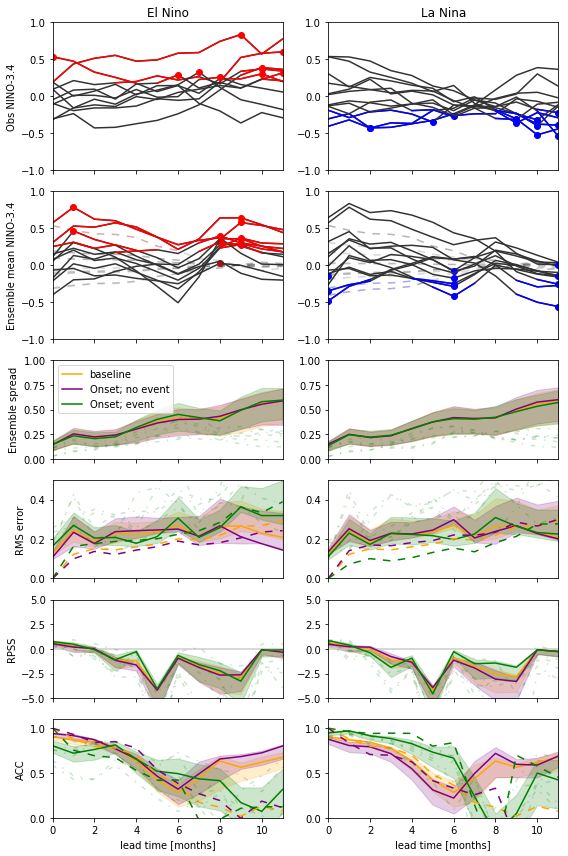

In [62]:
fig = plt.figure(figsize=(8, 12))
ax = fig.subplots(6,2, gridspec_kw={'height_ratios':[1.5, 1.5, 1, 1, 1, 1]})
linestyles = {'loosely dotted' : (0, (1, 10)),
              'dotted' : (0, (1, 5)),
              'loosely dashed' : (0, (5, 10)),
              'dashed' : (0, (5, 5)),
              'loosely dashdotted' : (0, (3, 10, 1, 10)),
              'dashdotted' : (0, (3, 5, 1, 5))}

for i in range(max(elnino_prezero.values)):
    idx=np.where(elnino_prezero.values == i+1)[0].item()
    try:
        ax[0,0].plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        ax[0,0].plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
        ax[0,0].plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).max(), marker='o', color='r')
    except:
        pass
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel('Obs NINO-3.4')
ax[0,0].set_xlim(0,11)
ax[0,0].set_ylim(-1,1)
ax[0,0].set_title('El Nino')

for i in range(max(lanina_prezero.values)):
    idx=np.where(lanina_prezero.values == i+1)[0].item()
    try:
        ax[0,1].plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        ax[0,1].plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
        ax[0,1].plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).min(), marker='o', color='b')
    except:
        pass
ax[0,1].set_xticklabels([])
ax[0,1].set_ylabel('')
ax[0,1].set_xlim(0,11)
ax[0,1].set_ylim(-1,1)
ax[0,1].set_title('La Nina')

for i in range(max(elnino_prezero.values)):
    idx=np.where(elnino_prezero.values == i+1)[0].item()
    try:
        ax[1,0].plot(np.arange(12), stat_use.isel(init_date=idx), color=(0.2,0.2,0.2),linestyle=linestyles['dashed'], alpha=0.2)
        ax[1,0].plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) > threshold),linestyle=linestyles['dashed'], color='r', alpha=0.2)
        
        ax[1,0].plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx), color=(0.2,0.2,0.2))
        ax[1,0].plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) > threshold), color='r')
        ax[1,0].plot(fcst_use.mean('ensemble').isel(init_date=idx).argmax().item(), fcst_use.mean('ensemble').isel(init_date=idx).max(), marker='o', color='r')
    except:
        pass
ax[1,0].set_xticklabels([])
ax[1,0].set_ylabel('Ensemble mean NINO-3.4')
ax[1,0].set_xlim(0,11)
ax[1,0].set_ylim(-1,1)

for i in range(max(lanina_prezero.values)):
    idx=np.where(lanina_prezero.values == i+1)[0].item()
    try:
        ax[1,1].plot(np.arange(12), stat_use.isel(init_date=idx), color=(0.2,0.2,0.2),linestyle=linestyles['dashed'], alpha=0.2)
        ax[1,1].plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) < -threshold),linestyle=linestyles['dashed'], color='b', alpha=0.2)
        
        ax[1,1].plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx), color=(0.2,0.2,0.2))
        ax[1,1].plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) < -threshold), color='b')
        ax[1,1].plot(fcst_use.mean('ensemble').isel(init_date=idx).argmin().item(), fcst_use.mean('ensemble').isel(init_date=idx).min(), marker='o', color='b')
    except:
        pass
ax[1,1].set_xticklabels([])
ax[1,1].set_ylabel('')
ax[1,1].set_xlim(0,11)
ax[1,1].set_ylim(-1,1)

elnino_onset_baseline_spread.plot(ax=ax[2,0],color='orange')
ax[2,0].fill_between(elnino_onset_baseline_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_baseline_spread_bs.isel(quantiles=1),
                     elnino_onset_baseline_spread_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_onset_noevent_spread.plot(ax=ax[2,0],color='purple')
ax[2,0].fill_between(elnino_onset_noevent_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_noevent_spread_bs.isel(quantiles=1),
                     elnino_onset_noevent_spread_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_onset_event_spread.plot(ax=ax[2,0],color='green')
ax[2,0].fill_between(elnino_onset_event_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_event_spread_bs.isel(quantiles=1),
                     elnino_onset_event_spread_bs.isel(quantiles=0), color='green', alpha=0.2)
elnino_onset_event_spread_cola.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_spread_aer04.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_spread_florA.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_spread_florB.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_spread_cm3.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_spread_cm4.plot(ax=ax[2,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[2,0].set_xticklabels([])
ax[2,0].set_xlabel('')
ax[2,0].set_ylabel('Ensemble spread')
ax[2,0].set_xlim(0,11)
ax[2,0].set_ylim(0,1)
ax[2,0].legend(['baseline','Onset; no event','Onset; event'])

lanina_onset_baseline_spread.plot(ax=ax[2,1],color='orange')
ax[2,1].fill_between(lanina_onset_baseline_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_baseline_spread_bs.isel(quantiles=1),
                     lanina_onset_baseline_spread_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_onset_noevent_spread.plot(ax=ax[2,1],color='purple')
ax[2,1].fill_between(lanina_onset_noevent_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_noevent_spread_bs.isel(quantiles=1),
                     lanina_onset_noevent_spread_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_onset_event_spread.plot(ax=ax[2,1],color='green')
ax[2,1].fill_between(lanina_onset_event_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_event_spread_bs.isel(quantiles=1),
                     lanina_onset_event_spread_bs.isel(quantiles=0), color='green', alpha=0.2)
lanina_onset_event_spread_cola.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_spread_aer04.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_spread_florA.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_spread_florB.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_spread_cm3.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_spread_cm4.plot(ax=ax[2,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[2,1].set_xticklabels([])
ax[2,1].set_xlabel('')
ax[2,1].set_ylabel('')
ax[2,1].set_xlim(0,11)
ax[2,1].set_ylim(0,1)

elnino_onset_baseline_rms.plot(ax=ax[3,0],color='orange')
ax[3,0].fill_between(elnino_onset_baseline_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_baseline_rms_bs.isel(quantiles=1),
                     elnino_onset_baseline_rms_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_onset_noevent_rms.plot(ax=ax[3,0],color='purple')
ax[3,0].fill_between(elnino_onset_noevent_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_noevent_rms_bs.isel(quantiles=1),
                     elnino_onset_noevent_rms_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_onset_event_rms.plot(ax=ax[3,0],color='green')
ax[3,0].fill_between(elnino_onset_event_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_event_rms_bs.isel(quantiles=1),
                     elnino_onset_event_rms_bs.isel(quantiles=0), color='green', alpha=0.2)
elnino_onset_baseline_rms_stat.plot(ax=ax[3,0],linestyle=linestyles['dashed'],color='orange')
elnino_onset_noevent_rms_stat.plot(ax=ax[3,0],linestyle=linestyles['dashed'],color='purple')
elnino_onset_event_rms_stat.plot(ax=ax[3,0],linestyle=linestyles['dashed'],color='green')
elnino_onset_event_rms_cola.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rms_aer04.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rms_florA.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rms_florB.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rms_cm3.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rms_cm4.plot(ax=ax[3,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[3,0].set_xticklabels([])
ax[3,0].set_xlabel('')
ax[3,0].set_ylabel('RMS error')
ax[3,0].set_xlim(0,11)
ax[3,0].set_ylim(0,0.5)

lanina_onset_baseline_rms.plot(ax=ax[3,1],color='orange')
ax[3,1].fill_between(lanina_onset_baseline_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_baseline_rms_bs.isel(quantiles=1),
                     lanina_onset_baseline_rms_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_onset_noevent_rms.plot(ax=ax[3,1],color='purple')
ax[3,1].fill_between(lanina_onset_noevent_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_noevent_rms_bs.isel(quantiles=1),
                     lanina_onset_noevent_rms_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_onset_event_rms.plot(ax=ax[3,1],color='green')
ax[3,1].fill_between(lanina_onset_event_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_event_rms_bs.isel(quantiles=1),
                     lanina_onset_event_rms_bs.isel(quantiles=0), color='green', alpha=0.2)
lanina_onset_baseline_rms_stat.plot(ax=ax[3,1],linestyle=linestyles['dashed'],color='orange')
lanina_onset_noevent_rms_stat.plot(ax=ax[3,1],linestyle=linestyles['dashed'],color='purple')
lanina_onset_event_rms_stat.plot(ax=ax[3,1],linestyle=linestyles['dashed'],color='green')
lanina_onset_event_rms_cola.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rms_aer04.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rms_florA.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rms_florB.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rms_cm3.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rms_cm4.plot(ax=ax[3,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[3,1].set_xticklabels([])
ax[3,1].set_xlabel('')
ax[3,1].set_ylabel('')
ax[3,1].set_xlim(0,11)
ax[3,1].set_ylim(0,0.5)

ax[4,0].plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
elnino_onset_baseline_rpss.plot(ax=ax[4,0],color='orange')
ax[4,0].fill_between(elnino_onset_baseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_baseline_rpss_bs.isel(quantiles=1),
                     elnino_onset_baseline_rpss_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_onset_noevent_rpss.plot(ax=ax[4,0],color='purple')
ax[4,0].fill_between(elnino_onset_noevent_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_noevent_rpss_bs.isel(quantiles=1),
                     elnino_onset_noevent_rpss_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_onset_event_rpss.plot(ax=ax[4,0],color='green')
ax[4,0].fill_between(elnino_onset_event_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_event_rpss_bs.isel(quantiles=1),
                     elnino_onset_event_rpss_bs.isel(quantiles=0), color='green', alpha=0.2)
elnino_onset_event_rpss_cola.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rpss_aer04.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rpss_florA.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rpss_florB.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rpss_cm3.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_rpss_cm4.plot(ax=ax[4,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[4,0].set_xticklabels([])
ax[4,0].set_xlabel('')
ax[4,0].set_ylabel('RPSS')
ax[4,0].set_xlim(0,11)
ax[4,0].set_ylim(-5,5)

ax[4,1].plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
lanina_onset_baseline_rpss.plot(ax=ax[4,1],color='orange')
ax[4,1].fill_between(lanina_onset_baseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_baseline_rpss_bs.isel(quantiles=1),
                     lanina_onset_baseline_rpss_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_onset_noevent_rpss.plot(ax=ax[4,1],color='purple')
ax[4,1].fill_between(lanina_onset_noevent_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_noevent_rpss_bs.isel(quantiles=1),
                     lanina_onset_noevent_rpss_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_onset_event_rpss.plot(ax=ax[4,1],color='green')
ax[4,1].fill_between(lanina_onset_event_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_event_rpss_bs.isel(quantiles=1),
                     lanina_onset_event_rpss_bs.isel(quantiles=0), color='green', alpha=0.2)
lanina_onset_event_rpss_cola.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rpss_aer04.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rpss_florA.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rpss_florB.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rpss_cm3.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_rpss_cm4.plot(ax=ax[4,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[4,1].set_xticklabels([])
ax[4,1].set_xlabel('')
ax[4,1].set_ylabel('')
ax[4,1].set_xlim(0,11)
ax[4,1].set_ylim(-5,5)

elnino_onset_baseline_acc.plot(ax=ax[5,0],color='orange')
ax[5,0].fill_between(elnino_onset_baseline_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_baseline_acc_bs.isel(quantiles=1),
                     elnino_onset_baseline_acc_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_onset_noevent_acc.plot(ax=ax[5,0],color='purple')
ax[5,0].fill_between(elnino_onset_noevent_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_noevent_acc_bs.isel(quantiles=1),
                     elnino_onset_noevent_acc_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_onset_event_acc.plot(ax=ax[5,0],color='green')
ax[5,0].fill_between(elnino_onset_event_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_onset_event_acc_bs.isel(quantiles=1),
                     elnino_onset_event_acc_bs.isel(quantiles=0), color='green', alpha=0.2)
elnino_onset_baseline_acc_stat.plot(ax=ax[5,0],linestyle=linestyles['dashed'],color='orange')
elnino_onset_noevent_acc_stat.plot(ax=ax[5,0],linestyle=linestyles['dashed'],color='purple')
elnino_onset_event_acc_stat.plot(ax=ax[5,0],linestyle=linestyles['dashed'],color='green')
elnino_onset_event_acc_cola.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_acc_aer04.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_acc_florA.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_acc_florB.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_acc_cm3.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
elnino_onset_event_acc_cm4.plot(ax=ax[5,0],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[5,0].set_xlabel('lead time [months]')
ax[5,0].set_ylabel('ACC')
ax[5,0].set_xlim(0,11)
ax[5,0].set_ylim(0,1.1)

lanina_onset_baseline_acc.plot(ax=ax[5,1],color='orange')
ax[5,1].fill_between(lanina_onset_baseline_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_baseline_acc_bs.isel(quantiles=1),
                     lanina_onset_baseline_acc_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_onset_noevent_acc.plot(ax=ax[5,1],color='purple')
ax[5,1].fill_between(lanina_onset_noevent_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_noevent_acc_bs.isel(quantiles=1),
                     lanina_onset_noevent_acc_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_onset_event_acc.plot(ax=ax[5,1],color='green')
ax[5,1].fill_between(lanina_onset_event_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_onset_event_acc_bs.isel(quantiles=1),
                     lanina_onset_event_acc_bs.isel(quantiles=0), color='green', alpha=0.2)
lanina_onset_baseline_acc_stat.plot(ax=ax[5,1],linestyle=linestyles['dashed'],color='orange')
lanina_onset_noevent_acc_stat.plot(ax=ax[5,1],linestyle=linestyles['dashed'],color='purple')
lanina_onset_event_acc_stat.plot(ax=ax[5,1],linestyle=linestyles['dashed'],color='green')
lanina_onset_event_acc_cola.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_acc_aer04.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_acc_florA.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_acc_florB.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_acc_cm3.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
lanina_onset_event_acc_cm4.plot(ax=ax[5,1],linestyle=linestyles['dashdotted'],color='green', alpha=0.2)
ax[5,1].set_xlabel('lead time [months]')
ax[5,1].set_ylabel('')
ax[5,1].set_xlim(0,11)
ax[5,1].set_ylim(0,1.1)

fig.tight_layout()

plt.savefig(saveloc + 'atlantic_onset.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'atlantic_onset.png', dpi=600, format='png', bbox_inches='tight')

# El Nino peak
1. **baseline** - assess all forecasts starting in `peak_month`
2. **peak baseline** - assess only forecasts starting from peak El Nino
3. **El Nino -> La Nina** - assess only forecasts starting from peak El Nino that are immediately followed by a La Nina
4. **El Nino zero point** - assess only forecasts starting from the `zero_month` between El Nino and La Nina

#### Root mean squared error

In [63]:
elnino_peak_baseline_rms = doppyo.skill.rms_error(fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('ensemble'),
                                                  obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])

elnino_peak_peakbaseline_rms = doppyo.skill.rms_error(fcst_use.where(elnino_max, drop=True).mean('ensemble'),
                                                      obsv_use.where(elnino_max, drop=True), over_dims=['init_date'])

elnino_peak_el2la_rms = doppyo.skill.rms_error(fcst_use.where(elnino_lanina_max, drop=True).mean('ensemble'),
                                               obsv_use.where(elnino_lanina_max, drop=True), over_dims=['init_date'])

elnino_peak_el2lazero_rms = doppyo.skill.rms_error(fcst_use.where(elnino_lanina_postzero, drop=True).mean('ensemble'),
                                                   obsv_use.where(elnino_lanina_postzero, drop=True), over_dims=['init_date'])

# Statistical forecasts -----
elnino_peak_baseline_rms_stat = doppyo.skill.rms_error(stat_use.where(stat_use.init_date.dt.month == peak_month, drop=True),
                                                  obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])

elnino_peak_peakbaseline_rms_stat = doppyo.skill.rms_error(stat_use.where(elnino_max, drop=True),
                                                      obsv_use.where(elnino_max, drop=True), over_dims=['init_date'])

elnino_peak_el2la_rms_stat = doppyo.skill.rms_error(stat_use.where(elnino_lanina_max, drop=True),
                                               obsv_use.where(elnino_lanina_max, drop=True), over_dims=['init_date'])

elnino_peak_el2lazero_rms_stat = doppyo.skill.rms_error(stat_use.where(elnino_lanina_postzero, drop=True),
                                                   obsv_use.where(elnino_lanina_postzero, drop=True), over_dims=['init_date'])

# Add indiviual models ---
lanina_onset_event_rms_cola = doppyo.skill.rms_error(cola_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_aer04 = doppyo.skill.rms_error(aer04_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_florA = doppyo.skill.rms_error(florA_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_florB = doppyo.skill.rms_error(florB_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_cm3 = doppyo.skill.rms_error(cm3_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

lanina_onset_event_rms_cm4 = doppyo.skill.rms_error(cm4_atlntc_sbc.where(lanina_prezero, drop=True).mean('ensemble'),
                                                     obsv_use.where(lanina_prezero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [64]:
elnino_peak_baseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True),
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True,
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])
elnino_peak_baseline_rms_bs = xr.concat([elnino_peak_baseline_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_baseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_peakbaseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(elnino_max, drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(elnino_max, drop=True), 
                                               over_dims=['init_date'])
elnino_peak_peakbaseline_rms_bs = xr.concat([elnino_peak_peakbaseline_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_peakbaseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2la_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(elnino_lanina_max, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(elnino_lanina_max, drop=True), 
                                             over_dims=['init_date'])
elnino_peak_el2la_rms_bs = xr.concat([elnino_peak_el2la_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2la_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2lazero_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(elnino_lanina_postzero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(elnino_lanina_postzero, drop=True), 
                                             over_dims=['init_date'])
elnino_peak_el2lazero_rms_bs = xr.concat([elnino_peak_el2lazero_rms_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2lazero_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ranked probability skill score

##### Forecasts

In [65]:
elnino_peak_rps = doppyo.skill.rps(fcst_use, obsv_use, bins=bins, over_dims=None)

elnino_peak_baseline_rps = elnino_peak_rps.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('init_date')

elnino_peak_peakbaseline_rps = elnino_peak_rps.where(elnino_max, drop=True).mean('init_date')

elnino_peak_el2la_rps = elnino_peak_rps.where(elnino_lanina_max, drop=True).mean('init_date')

elnino_peak_el2lazero_rps = elnino_peak_rps.where(elnino_lanina_postzero, drop=True).mean('init_date')

##### Climatological weight

In [66]:
clim = obsv_use_ts.sel(init_date=slice('1971','2000'))

bin_edges = doppyo.utils.get_bin_edges(bins)
prob_in_bin = []
for e in range(len(bin_edges)-1):
    prob_in_bin.append(((clim >= bin_edges[e]) & (clim < bin_edges[e+1])).groupby('init_date.month').mean('init_date', skipna=True) / (bin_edges[e+1] - bin_edges[e]))

pdf_cmp = xr.concat(prob_in_bin, dim='bins')
pdf_cmp['bins'] = bins

cdf_cmp = doppyo.utils.integrate(pdf_cmp, over_dim='bins', method='rect', cumulative=True)
cdf_cmp = (0 * obsv_use).groupby('init_date').apply(lambda_anomalize, clim=-cdf_cmp)

cdf_ref = doppyo.utils.cdf(obsv_use, bin_edges=bin_edges, over_dims=None)

elnino_peak_rpsc = doppyo.utils.integrate((cdf_cmp - cdf_ref) ** 2, over_dim='bins')

elnino_peak_zerobaseline_rpsc = doppyo.utils.integrate((cdf_cmp.where(fcst_use.init_date.dt.month == zero_month, drop=True) - 
                                                        cdf_ref.where(obsv_use.init_date.dt.month == zero_month, drop=True)) ** 2, over_dim='bins').mean('init_date')

elnino_peak_peakbaseline_rpsc = doppyo.utils.integrate((cdf_cmp.where(fcst_use.init_date.dt.month == peak_month, drop=True) - 
                                                        cdf_ref.where(obsv_use.init_date.dt.month == peak_month, drop=True)) ** 2, over_dim='bins').mean('init_date')

In [67]:
elnino_peak_baseline_rpss = 1 - elnino_peak_baseline_rps / elnino_peak_peakbaseline_rpsc

elnino_peak_peakbaseline_rpss = 1 - elnino_peak_peakbaseline_rps / elnino_peak_peakbaseline_rpsc

elnino_peak_el2la_rpss = 1 - elnino_peak_el2la_rps / elnino_peak_peakbaseline_rpsc

elnino_peak_el2lazero_rpss = 1 - elnino_peak_el2lazero_rps / elnino_peak_zerobaseline_rpsc

##### Bootstrapped error bars

In [68]:
elnino_peak_rps_bs = bootstrap_metric(doppyo.skill.rps, fcst_use, n_ens=n_ens, n_bootstrap=n_bootstrap, da_ref=obsv_use, bins=bins, over_dims=None)

elnino_peak_baseline_rpss_bs = 1 - elnino_peak_rps_bs.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('init_date') / elnino_peak_peakbaseline_rpsc
elnino_peak_baseline_rpss_bs = xr.concat([elnino_peak_baseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_baseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_peakbaseline_rpss_bs = 1 - elnino_peak_rps_bs.where(elnino_max, drop=True).mean('init_date') / elnino_peak_peakbaseline_rpsc
elnino_peak_peakbaseline_rpss_bs = xr.concat([elnino_peak_peakbaseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_peakbaseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2la_rpss_bs = 1 - elnino_peak_rps_bs.where(elnino_lanina_max, drop=True).mean('init_date') / elnino_peak_peakbaseline_rpsc
elnino_peak_el2la_rpss_bs = xr.concat([elnino_peak_el2la_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2la_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2lazero_rpss_bs = 1 - elnino_peak_rps_bs.where(elnino_lanina_postzero, drop=True).mean('init_date') / elnino_peak_zerobaseline_rpsc
elnino_peak_el2lazero_rpss_bs = xr.concat([elnino_peak_el2lazero_rpss_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2lazero_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Anomaly cross correlation

In [69]:
elnino_peak_baseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('ensemble'),
                                                          obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')

elnino_peak_peakbaseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(elnino_max, drop=True).mean('ensemble'),
                                                              obsv_use.where(elnino_max, drop=True), over_dims='init_date')

elnino_peak_el2la_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(elnino_lanina_max, drop=True).mean('ensemble'),
                                                       obsv_use.where(elnino_lanina_max, drop=True), over_dims='init_date')

elnino_peak_el2lan_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(elnino_laneut_max, drop=True).mean('ensemble'),
                                                        obsv_use.where(elnino_laneut_max, drop=True), over_dims='init_date')

elnino_peak_el2lazero_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(elnino_lanina_postzero, drop=True).mean('ensemble'),
                                                           obsv_use.where(elnino_lanina_postzero, drop=True), over_dims='init_date')

# Statistical forecasts -----
elnino_peak_baseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(stat_use.init_date.dt.month == peak_month, drop=True),
                                                               obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')

elnino_peak_peakbaseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(elnino_max, drop=True),
                                                              obsv_use.where(elnino_max, drop=True), over_dims='init_date')

elnino_peak_el2la_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(elnino_lanina_max, drop=True),
                                                       obsv_use.where(elnino_lanina_max, drop=True), over_dims='init_date')

elnino_peak_el2lazero_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(elnino_lanina_postzero, drop=True),
                                                           obsv_use.where(elnino_lanina_postzero, drop=True), over_dims='init_date')

##### Bootstrapped error bars

In [70]:
elnino_peak_baseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, 
                                               avg_ensemble=True, da_ref=obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')
elnino_peak_baseline_acc_bs = xr.concat([elnino_peak_baseline_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_baseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_peakbaseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(elnino_max, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                   da_ref=obsv_use.where(elnino_max, drop=True), over_dims='init_date')
elnino_peak_peakbaseline_acc_bs = xr.concat([elnino_peak_peakbaseline_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_peakbaseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2la_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(elnino_lanina_max, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(elnino_lanina_max, drop=True), over_dims='init_date')
elnino_peak_el2la_acc_bs = xr.concat([elnino_peak_el2la_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2la_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2lan_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(elnino_laneut_max, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(elnino_laneut_max, drop=True), over_dims='init_date')
elnino_peak_el2lan_acc_bs = xr.concat([elnino_peak_el2lan_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2lan_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

elnino_peak_el2lazero_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(elnino_lanina_postzero, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(elnino_lanina_postzero, drop=True), over_dims='init_date')
elnino_peak_el2lazero_acc_bs = xr.concat([elnino_peak_el2lazero_acc_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2lazero_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ensemble spread

In [71]:
elnino_peak_baseline_spread = fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).std('ensemble').mean('init_date')

elnino_peak_peakbaseline_spread = fcst_use.where(elnino_max, drop=True).std('ensemble').mean('init_date')

elnino_peak_el2la_spread = fcst_use.where(elnino_lanina_max, drop=True).std('ensemble').mean('init_date')

elnino_peak_el2lazero_spread = fcst_use.where(elnino_lanina_postzero, drop=True).std('ensemble').mean('init_date')

##### Bootstrapped error bars

In [72]:
elnino_peak_baseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_peak_baseline_spread_bs = xr.concat([elnino_peak_baseline_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_baseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

elnino_peak_peakbaseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(elnino_max, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_peak_peakbaseline_spread_bs = xr.concat([elnino_peak_peakbaseline_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_peakbaseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

elnino_peak_el2la_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(elnino_lanina_max, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_peak_el2la_spread_bs = xr.concat([elnino_peak_el2la_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2la_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

elnino_peak_el2lazero_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(elnino_lanina_postzero, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
elnino_peak_el2lazero_spread_bs = xr.concat([elnino_peak_el2lazero_spread_bs.quantile(0.05, dim='bootstrap sample'), elnino_peak_el2lazero_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

# La Nina peak
1. **baseline** - assess all forecasts starting in `peak_month`
2. **peak baseline** - assess only forecasts starting from peak La Nina
3. **La Nina -> El Nino** - assess only forecasts starting from peak La Nina that are immediately followed by an El Nino
4. **La Nina zero point** - assess only forecasts starting from the `zero_month` between La Nina and El Nino

#### Root mean squared error

In [73]:
lanina_peak_baseline_rms = doppyo.skill.rms_error(fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('ensemble'),
                                                  obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])

lanina_peak_peakbaseline_rms = doppyo.skill.rms_error(fcst_use.where(lanina_min, drop=True).mean('ensemble'),
                                                      obsv_use.where(lanina_min, drop=True), over_dims=['init_date'])

lanina_peak_la2el_rms = doppyo.skill.rms_error(fcst_use.where(lanina_elnino_min, drop=True).mean('ensemble'),
                                               obsv_use.where(lanina_elnino_min, drop=True), over_dims=['init_date'])

lanina_peak_la2elzero_rms = doppyo.skill.rms_error(fcst_use.where(lanina_elnino_postzero, drop=True).mean('ensemble'),
                                                   obsv_use.where(lanina_elnino_postzero, drop=True), over_dims=['init_date'])

# Statistical forecasts -----
lanina_peak_baseline_rms_stat = doppyo.skill.rms_error(stat_use.where(stat_use.init_date.dt.month == peak_month, drop=True),
                                                  obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])

lanina_peak_peakbaseline_rms_stat = doppyo.skill.rms_error(stat_use.where(lanina_min, drop=True),
                                                      obsv_use.where(lanina_min, drop=True), over_dims=['init_date'])

lanina_peak_la2el_rms_stat = doppyo.skill.rms_error(stat_use.where(lanina_elnino_min, drop=True),
                                               obsv_use.where(lanina_elnino_min, drop=True), over_dims=['init_date'])

lanina_peak_la2elzero_rms_stat = doppyo.skill.rms_error(stat_use.where(lanina_elnino_postzero, drop=True),
                                                   obsv_use.where(lanina_elnino_postzero, drop=True), over_dims=['init_date'])

##### Bootstrapped error bars

In [74]:
lanina_peak_baseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True),
                                                n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True,
                                                da_ref=obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims=['init_date'])
lanina_peak_baseline_rms_bs = xr.concat([lanina_peak_baseline_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_baseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_peakbaseline_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(lanina_min, drop=True), 
                                               n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(lanina_min, drop=True), 
                                               over_dims=['init_date'])
lanina_peak_peakbaseline_rms_bs = xr.concat([lanina_peak_peakbaseline_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_peakbaseline_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2el_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(lanina_elnino_min, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(lanina_elnino_min, drop=True), 
                                             over_dims=['init_date'])
lanina_peak_la2el_rms_bs = xr.concat([lanina_peak_la2el_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2el_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2elzero_rms_bs = bootstrap_metric(doppyo.skill.rms_error, fcst_use.where(lanina_elnino_postzero, drop=True), 
                                             n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, da_ref=obsv_use.where(lanina_elnino_postzero, drop=True), 
                                             over_dims=['init_date'])
lanina_peak_la2elzero_rms_bs = xr.concat([lanina_peak_la2elzero_rms_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2elzero_rms_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ranked probability skill score

##### Forecasts

In [75]:
lanina_peak_rps = doppyo.skill.rps(fcst_use, obsv_use, bins=bins, over_dims=None)

lanina_peak_baseline_rps = lanina_peak_rps.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('init_date')

lanina_peak_peakbaseline_rps = lanina_peak_rps.where(lanina_min, drop=True).mean('init_date')

lanina_peak_la2el_rps = lanina_peak_rps.where(lanina_elnino_min, drop=True).mean('init_date')

lanina_peak_la2elzero_rps = lanina_peak_rps.where(lanina_elnino_postzero, drop=True).mean('init_date')

##### Climatological weight

In [76]:
lanina_peak_zerobaseline_rpsc = elnino_peak_zerobaseline_rpsc

lanina_peak_peakbaseline_rpsc = elnino_peak_peakbaseline_rpsc

In [77]:
lanina_peak_baseline_rpss = 1 - lanina_peak_baseline_rps / lanina_peak_peakbaseline_rpsc

lanina_peak_peakbaseline_rpss = 1 - lanina_peak_peakbaseline_rps / lanina_peak_peakbaseline_rpsc

lanina_peak_la2el_rpss = 1 - lanina_peak_la2el_rps / lanina_peak_peakbaseline_rpsc

lanina_peak_la2elzero_rpss = 1 - lanina_peak_la2elzero_rps / lanina_peak_zerobaseline_rpsc

##### Bootstrapped error bars

In [78]:
lanina_peak_rps_bs = bootstrap_metric(doppyo.skill.rps, fcst_use, n_ens=n_ens, n_bootstrap=n_bootstrap, da_ref=obsv_use, bins=bins, over_dims=None)

lanina_peak_baseline_rpss_bs = 1 - lanina_peak_rps_bs.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('init_date') / lanina_peak_peakbaseline_rpsc
lanina_peak_baseline_rpss_bs = xr.concat([lanina_peak_baseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_baseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_peakbaseline_rpss_bs = 1 - lanina_peak_rps_bs.where(lanina_min, drop=True).mean('init_date') / lanina_peak_peakbaseline_rpsc
lanina_peak_peakbaseline_rpss_bs = xr.concat([lanina_peak_peakbaseline_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_peakbaseline_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2el_rpss_bs = 1 - lanina_peak_rps_bs.where(lanina_elnino_min, drop=True).mean('init_date') / lanina_peak_peakbaseline_rpsc
lanina_peak_la2el_rpss_bs = xr.concat([lanina_peak_la2el_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2el_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2elzero_rpss_bs = 1 - lanina_peak_rps_bs.where(lanina_elnino_postzero, drop=True).mean('init_date') / lanina_peak_zerobaseline_rpsc
lanina_peak_la2elzero_rpss_bs = xr.concat([lanina_peak_la2elzero_rpss_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2elzero_rpss_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Anomaly cross correlation

In [79]:
lanina_peak_baseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).mean('ensemble'),
                                                          obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')

lanina_peak_peakbaseline_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(lanina_min, drop=True).mean('ensemble'),
                                                              obsv_use.where(lanina_min, drop=True), over_dims='init_date')

lanina_peak_la2el_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(lanina_elnino_min, drop=True).mean('ensemble'),
                                                       obsv_use.where(lanina_elnino_min, drop=True), over_dims='init_date')

lanina_peak_la2eln_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(lanina_elneut_min, drop=True).mean('ensemble'),
                                                      obsv_use.where(lanina_elneut_min, drop=True), over_dims='init_date')

lanina_peak_la2elzero_acc = doppyo.skill.Pearson_corrcoeff(fcst_use.where(lanina_elnino_postzero, drop=True).mean('ensemble'),
                                                           obsv_use.where(lanina_elnino_postzero, drop=True), over_dims='init_date')

# Statistical forecasts -----
lanina_peak_baseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(stat_use.init_date.dt.month == peak_month, drop=True),
                                                               obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')

lanina_peak_peakbaseline_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(lanina_min, drop=True),
                                                                   obsv_use.where(lanina_min, drop=True), over_dims='init_date')

lanina_peak_la2el_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(lanina_elnino_min, drop=True),
                                                            obsv_use.where(lanina_elnino_min, drop=True), over_dims='init_date')

lanina_peak_la2elzero_acc_stat = doppyo.skill.Pearson_corrcoeff(stat_use.where(lanina_elnino_postzero, drop=True),
                                                                obsv_use.where(lanina_elnino_postzero, drop=True), over_dims='init_date')

##### Bootstrapped error bars

In [80]:
lanina_peak_baseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, 
                                               avg_ensemble=True, da_ref=obsv_use.where(obsv_use.init_date.dt.month == peak_month, drop=True), over_dims='init_date')
lanina_peak_baseline_acc_bs = xr.concat([lanina_peak_baseline_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_baseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_peakbaseline_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(lanina_min, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                                   da_ref=obsv_use.where(lanina_min, drop=True), over_dims='init_date')
lanina_peak_peakbaseline_acc_bs = xr.concat([lanina_peak_peakbaseline_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_peakbaseline_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2el_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(lanina_elnino_min, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(lanina_elnino_min, drop=True), over_dims='init_date')
lanina_peak_la2el_acc_bs = xr.concat([lanina_peak_la2el_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2el_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2eln_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(lanina_elneut_min, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(lanina_elneut_min, drop=True), over_dims='init_date')
lanina_peak_la2eln_acc_bs = xr.concat([lanina_peak_la2eln_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2eln_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

lanina_peak_la2elzero_acc_bs = bootstrap_metric(doppyo.skill.Pearson_corrcoeff, fcst_use.where(lanina_elnino_postzero, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap, avg_ensemble=True, 
                                            da_ref=obsv_use.where(lanina_elnino_postzero, drop=True), over_dims='init_date')
lanina_peak_la2elzero_acc_bs = xr.concat([lanina_peak_la2elzero_acc_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2elzero_acc_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles')

#### Ensemble spread

In [81]:
lanina_peak_baseline_spread = fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True).std('ensemble').mean('init_date')

lanina_peak_peakbaseline_spread = fcst_use.where(lanina_min, drop=True).std('ensemble').mean('init_date')

lanina_peak_la2el_spread = fcst_use.where(lanina_elnino_min, drop=True).std('ensemble').mean('init_date')

lanina_peak_la2elzero_spread = fcst_use.where(lanina_elnino_postzero, drop=True).std('ensemble').mean('init_date')

##### Bootstrapped error bars

In [82]:
lanina_peak_baseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(fcst_use.init_date.dt.month == peak_month, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_peak_baseline_spread_bs = xr.concat([lanina_peak_baseline_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_baseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

lanina_peak_peakbaseline_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(lanina_min, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_peak_peakbaseline_spread_bs = xr.concat([lanina_peak_peakbaseline_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_peakbaseline_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

lanina_peak_la2el_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(lanina_elnino_min, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_peak_la2el_spread_bs = xr.concat([lanina_peak_la2el_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2el_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

lanina_peak_la2elzero_spread_bs = bootstrap_metric(ensemble_std, fcst_use.where(lanina_elnino_postzero, drop=True), n_ens=n_ens, n_bootstrap=n_bootstrap)
lanina_peak_la2elzero_spread_bs = xr.concat([lanina_peak_la2elzero_spread_bs.quantile(0.05, dim='bootstrap sample'), lanina_peak_la2elzero_spread_bs.quantile(0.95, dim='bootstrap sample')], dim='quantiles').mean('init_date')

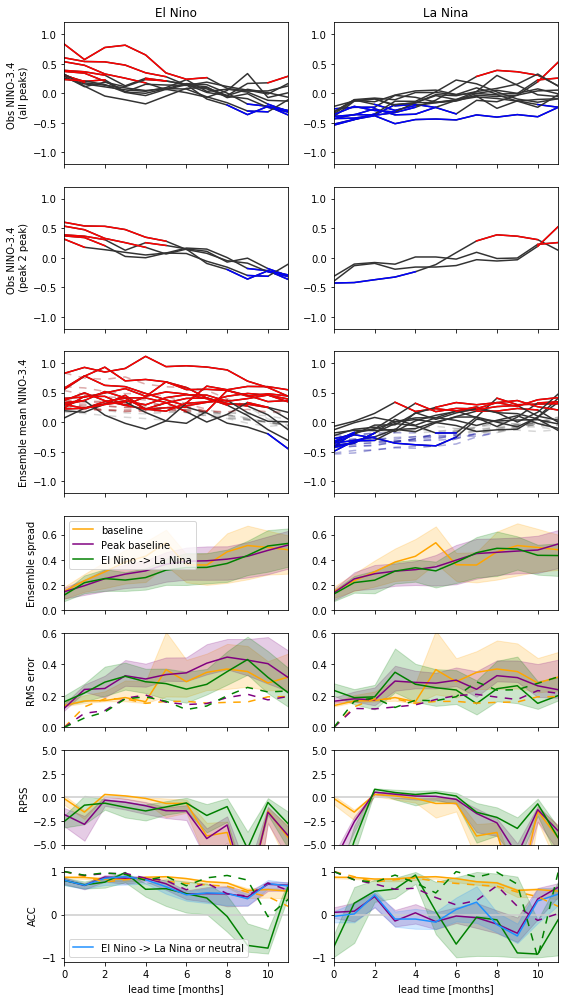

In [84]:
fig = plt.figure(figsize=(8, 14))
ax = fig.subplots(7,2, gridspec_kw={'height_ratios':[1.5, 1.5, 1.5, 1, 1, 1, 1]})

curr_ax = ax[0,0]
for i in range(int(max(elnino_max.values))):
    idx=np.where(elnino_max.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold).max(), marker='o', color='r')
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold).min(), marker='o', color='b')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('Obs NINO-3.4 \n (all peaks)')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)
curr_ax.set_title('El Nino')

curr_ax = ax[0,1]
for i in range(int(max(lanina_min.values))):
    idx=np.where(lanina_min.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold).min(), marker='o', color='b')
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold).max(), marker='o', color='r')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)
curr_ax.set_title('La Nina')

curr_ax = ax[1,0]
for i in range(int(max(elnino_lanina_max.values))):
    idx=np.where(elnino_lanina_max.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold).max(), marker='o', color='r')
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold).min(), marker='o', color='b')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('Obs NINO-3.4 \n (peak 2 peak)')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)

curr_ax = ax[1,1]
for i in range(int(max(lanina_elnino_min.values))):
    idx=np.where(lanina_elnino_min.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold).min(), marker='o', color='b')
        curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
        # curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold).max(), marker='o', color='r')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)

# curr_ax = ax[2,0]
# for i in range(int(max(elnino_lanina_postzero.values))):
#     idx=np.where(elnino_lanina_postzero.values == i+1)[0].item()
#     try:
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
#         curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold).min(), marker='o', color='b')
#     except:
#         pass
# curr_ax.set_xticklabels([])
# curr_ax.set_ylabel('Obs NINO-3.4 \n (peak 2 peak, zero+)')
# curr_ax.set_xlim(0,11)
# curr_ax.set_ylim(-3,3)

# curr_ax = ax[2,1]
# for i in range(int(max(lanina_elnino_postzero.values))):
#     idx=np.where(lanina_elnino_postzero.values == i+1)[0].item()
#     try:
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)), color=(0.2,0.2,0.2))
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) < -threshold), color='b')
#         #curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmin().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).min(), marker='o', color='b')
#         curr_ax.plot(np.arange(12), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold), color='r')
#         curr_ax.plot(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).argmax().item(), obsv_use_ts.isel(init_date=np.arange(idx,idx+12)).where(obsv_use_ts.isel(init_date=np.arange(idx,idx+12)) > threshold).max(), marker='o', color='r')
#     except:
#         pass
# curr_ax.set_xticklabels([])
# curr_ax.set_ylabel('')
# curr_ax.set_xlim(0,11)
# curr_ax.set_ylim(-3,3)

curr_ax = ax[2,0]
for i in range(int(max(elnino_max.values))):
    idx=np.where(elnino_max.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx), color=(0.2,0.2,0.2),linestyle=linestyles['dashed'], alpha=0.2)
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) > threshold),linestyle=linestyles['dashed'], color='r', alpha=0.2)
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) < -threshold),linestyle=linestyles['dashed'], color='b', alpha=0.2)
        
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) > threshold), color='r')
        # curr_ax.plot(fcst_use.mean('ensemble').isel(init_date=idx).argmax().item(), fcst_use.mean('ensemble').isel(init_date=idx).max(), marker='o', color='r')
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) < -threshold), color='b')
        # curr_ax.plot(fcst_use.mean('ensemble').isel(init_date=idx).argmin().item(), fcst_use.mean('ensemble').isel(init_date=idx).min(), marker='o', color='b')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('Ensemble mean NINO-3.4')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)

curr_ax = ax[2,1]
for i in range(int(max(lanina_min.values))):
    idx=np.where(lanina_min.values == i+1)[0].item()
    try:
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx), color=(0.2,0.2,0.2),linestyle=linestyles['dashed'], alpha=0.2)
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) > threshold),linestyle=linestyles['dashed'], color='r', alpha=0.2)
        curr_ax.plot(np.arange(12), stat_use.isel(init_date=idx).where(stat_use.isel(init_date=idx) < -threshold),linestyle=linestyles['dashed'], color='b', alpha=0.2)
        
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx), color=(0.2,0.2,0.2))
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) > threshold), color='r')
        # curr_ax.plot(fcst_use.mean('ensemble').isel(init_date=idx).argmax().item(), fcst_use.mean('ensemble').isel(init_date=idx).max(), marker='o', color='r')
        curr_ax.plot(np.arange(12), fcst_use.mean('ensemble').isel(init_date=idx).where(fcst_use.mean('ensemble').isel(init_date=idx) < -threshold), color='b')
        # curr_ax.plot(fcst_use.mean('ensemble').isel(init_date=idx).argmin().item(), fcst_use.mean('ensemble').isel(init_date=idx).min(), marker='o', color='b')
    except:
        pass
curr_ax.set_xticklabels([])
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.2,1.2)

curr_ax = ax[3,0]
elnino_peak_baseline_spread.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(elnino_peak_baseline_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_baseline_spread_bs.isel(quantiles=1),
                     elnino_peak_baseline_spread_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_peak_peakbaseline_spread.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(elnino_peak_peakbaseline_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_peakbaseline_spread_bs.isel(quantiles=1),
                     elnino_peak_peakbaseline_spread_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_peak_el2la_spread.plot(ax=curr_ax, color='green')
curr_ax.fill_between(elnino_peak_el2la_spread_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_el2la_spread_bs.isel(quantiles=1),
                     elnino_peak_el2la_spread_bs.isel(quantiles=0), color='green', alpha=0.2)
# elnino_peak_el2lazero_spread.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(elnino_peak_el2lazero_spread_bs.isel(quantiles=0).lead_time.values,
#                      elnino_peak_el2lazero_spread_bs.isel(quantiles=1),
#                      elnino_peak_el2lazero_spread_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('Ensemble spread')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(0,0.75)
curr_ax.legend(['baseline','Peak baseline','El Nino -> La Nina'])

curr_ax = ax[3,1]
lanina_peak_baseline_spread.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(lanina_peak_baseline_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_baseline_spread_bs.isel(quantiles=1),
                     lanina_peak_baseline_spread_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_peak_peakbaseline_spread.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(lanina_peak_peakbaseline_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_peakbaseline_spread_bs.isel(quantiles=1),
                     lanina_peak_peakbaseline_spread_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_peak_la2el_spread.plot(ax=curr_ax, color='green')
curr_ax.fill_between(lanina_peak_la2el_spread_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_la2el_spread_bs.isel(quantiles=1),
                     lanina_peak_la2el_spread_bs.isel(quantiles=0), color='green', alpha=0.2)
# lanina_peak_la2elzero_spread.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(lanina_peak_la2elzero_spread_bs.isel(quantiles=0).lead_time.values,
#                      lanina_peak_la2elzero_spread_bs.isel(quantiles=1),
#                      lanina_peak_la2elzero_spread_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(0,0.75)

curr_ax = ax[4,0]
elnino_peak_baseline_rms.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(elnino_peak_baseline_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_baseline_rms_bs.isel(quantiles=1),
                     elnino_peak_baseline_rms_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_peak_peakbaseline_rms.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(elnino_peak_peakbaseline_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_peakbaseline_rms_bs.isel(quantiles=1),
                     elnino_peak_peakbaseline_rms_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_peak_el2la_rms.plot(ax=curr_ax, color='green')
curr_ax.fill_between(elnino_peak_el2la_rms_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_el2la_rms_bs.isel(quantiles=1),
                     elnino_peak_el2la_rms_bs.isel(quantiles=0), color='green', alpha=0.2)
# elnino_peak_el2lazero_rms.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(elnino_peak_el2lazero_rms_bs.isel(quantiles=0).lead_time.values,
#                      elnino_peak_el2lazero_rms_bs.isel(quantiles=1),
#                      elnino_peak_el2lazero_rms_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
elnino_peak_baseline_rms_stat.plot(ax=curr_ax, color='orange',linestyle=linestyles['dashed'])
elnino_peak_peakbaseline_rms_stat.plot(ax=curr_ax, color='purple',linestyle=linestyles['dashed'])
elnino_peak_el2la_rms_stat.plot(ax=curr_ax, color='green',linestyle=linestyles['dashed'])
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('RMS error')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(0,0.6)

curr_ax = ax[4,1]
lanina_peak_baseline_rms.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(lanina_peak_baseline_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_baseline_rms_bs.isel(quantiles=1),
                     lanina_peak_baseline_rms_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_peak_peakbaseline_rms.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(lanina_peak_peakbaseline_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_peakbaseline_rms_bs.isel(quantiles=1),
                     lanina_peak_peakbaseline_rms_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_peak_la2el_rms.plot(ax=curr_ax, color='green')
curr_ax.fill_between(lanina_peak_la2el_rms_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_la2el_rms_bs.isel(quantiles=1),
                     lanina_peak_la2el_rms_bs.isel(quantiles=0), color='green', alpha=0.2)
# lanina_peak_la2elzero_rms.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(lanina_peak_la2elzero_rms_bs.isel(quantiles=0).lead_time.values,
#                      lanina_peak_la2elzero_rms_bs.isel(quantiles=1),
#                      lanina_peak_la2elzero_rms_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
lanina_peak_baseline_rms_stat.plot(ax=curr_ax, color='orange',linestyle=linestyles['dashed'])
lanina_peak_peakbaseline_rms_stat.plot(ax=curr_ax, color='purple',linestyle=linestyles['dashed'])
lanina_peak_la2el_rms_stat.plot(ax=curr_ax, color='green',linestyle=linestyles['dashed'])
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(0,0.6)

curr_ax = ax[5,0]
curr_ax.plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
elnino_peak_baseline_rpss.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(elnino_peak_baseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_baseline_rpss_bs.isel(quantiles=1),
                     elnino_peak_baseline_rpss_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_peak_peakbaseline_rpss.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(elnino_peak_peakbaseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_peakbaseline_rpss_bs.isel(quantiles=1),
                     elnino_peak_peakbaseline_rpss_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_peak_el2la_rpss.plot(ax=curr_ax, color='green')
curr_ax.fill_between(elnino_peak_el2la_rpss_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_el2la_rpss_bs.isel(quantiles=1),
                     elnino_peak_el2la_rpss_bs.isel(quantiles=0), color='green', alpha=0.2)
# elnino_peak_el2lazero_rpss.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(elnino_peak_el2lazero_rpss_bs.isel(quantiles=0).lead_time.values,
#                      elnino_peak_el2lazero_rpss_bs.isel(quantiles=1),
#                      elnino_peak_el2lazero_rpss_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('RPSS')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-5,5)

curr_ax = ax[5,1]
curr_ax.plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
lanina_peak_baseline_rpss.plot(ax=curr_ax, color='orange')
curr_ax.fill_between(lanina_peak_baseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_baseline_rpss_bs.isel(quantiles=1),
                     lanina_peak_baseline_rpss_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_peak_peakbaseline_rpss.plot(ax=curr_ax, color='purple')
curr_ax.fill_between(lanina_peak_peakbaseline_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_peakbaseline_rpss_bs.isel(quantiles=1),
                     lanina_peak_peakbaseline_rpss_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_peak_la2el_rpss.plot(ax=curr_ax, color='green')
curr_ax.fill_between(lanina_peak_la2el_rpss_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_la2el_rpss_bs.isel(quantiles=1),
                     lanina_peak_la2el_rpss_bs.isel(quantiles=0), color='green', alpha=0.2)
# lanina_peak_la2elzero_rpss.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(lanina_peak_la2elzero_rpss_bs.isel(quantiles=0).lead_time.values,
#                      lanina_peak_la2elzero_rpss_bs.isel(quantiles=1),
#                      lanina_peak_la2elzero_rpss_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
curr_ax.set_xticklabels([])
curr_ax.set_xlabel('')
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-5,5)

curr_ax = ax[6,0]
curr_ax.plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
elnino_peak_baseline_acc.plot(ax=curr_ax, color='orange', label='_nolegend_')
curr_ax.fill_between(elnino_peak_baseline_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_baseline_acc_bs.isel(quantiles=1),
                     elnino_peak_baseline_acc_bs.isel(quantiles=0), color='orange', alpha=0.2)
elnino_peak_peakbaseline_acc.plot(ax=curr_ax, color='purple', label='_nolegend_')
curr_ax.fill_between(elnino_peak_peakbaseline_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_peakbaseline_acc_bs.isel(quantiles=1),
                     elnino_peak_peakbaseline_acc_bs.isel(quantiles=0), color='purple', alpha=0.2)
elnino_peak_el2la_acc.plot(ax=curr_ax, color='green', label='_nolegend_')
curr_ax.fill_between(elnino_peak_el2la_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_el2la_acc_bs.isel(quantiles=1),
                     elnino_peak_el2la_acc_bs.isel(quantiles=0), color='green', alpha=0.2)
elnino_peak_el2lan_acc.plot(ax=curr_ax, color='dodgerblue', label='El Nino -> La Nina or neutral')
curr_ax.fill_between(elnino_peak_el2lan_acc_bs.isel(quantiles=0).lead_time.values,
                     elnino_peak_el2lan_acc_bs.isel(quantiles=1),
                     elnino_peak_el2lan_acc_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
# elnino_peak_el2lazero_acc.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(elnino_peak_el2lazero_acc_bs.isel(quantiles=0).lead_time.values,
#                      elnino_peak_el2lazero_acc_bs.isel(quantiles=1),
#                      elnino_peak_el2lazero_acc_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
elnino_peak_baseline_acc_stat.plot(ax=curr_ax, color='orange', label='_nolegend_',linestyle=linestyles['dashed'])
elnino_peak_peakbaseline_acc_stat.plot(ax=curr_ax, color='purple', label='_nolegend_',linestyle=linestyles['dashed'])
elnino_peak_el2la_acc_stat.plot(ax=curr_ax, color='green', label='_nolegend_',linestyle=linestyles['dashed'])
curr_ax.set_xlabel('lead time [months]')
curr_ax.set_ylabel('ACC')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.1,1.1)
curr_ax.legend()

curr_ax = ax[6,1]
curr_ax.plot([-1, 20],[0,0],color=(0.8,0.8,0.8))
lanina_peak_baseline_acc.plot(ax=curr_ax, color='orange', label='_nolegend_')
curr_ax.fill_between(lanina_peak_baseline_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_baseline_acc_bs.isel(quantiles=1),
                     lanina_peak_baseline_acc_bs.isel(quantiles=0), color='orange', alpha=0.2)
lanina_peak_peakbaseline_acc.plot(ax=curr_ax, color='purple', label='_nolegend_')
curr_ax.fill_between(lanina_peak_peakbaseline_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_peakbaseline_acc_bs.isel(quantiles=1),
                     lanina_peak_peakbaseline_acc_bs.isel(quantiles=0), color='purple', alpha=0.2)
lanina_peak_la2el_acc.plot(ax=curr_ax, color='green', label='_nolegend_')
curr_ax.fill_between(lanina_peak_la2el_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_la2el_acc_bs.isel(quantiles=1),
                     lanina_peak_la2el_acc_bs.isel(quantiles=0), color='green', alpha=0.2)
lanina_peak_la2eln_acc.plot(ax=curr_ax, color='dodgerblue', label='_nolegend_')
curr_ax.fill_between(lanina_peak_la2eln_acc_bs.isel(quantiles=0).lead_time.values,
                     lanina_peak_la2eln_acc_bs.isel(quantiles=1),
                     lanina_peak_la2eln_acc_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
# lanina_peak_la2elzero_acc.plot(ax=curr_ax, color='dodgerblue')
# curr_ax.fill_between(lanina_peak_la2elzero_acc_bs.isel(quantiles=0).lead_time.values,
#                      lanina_peak_la2elzero_acc_bs.isel(quantiles=1),
#                      lanina_peak_la2elzero_acc_bs.isel(quantiles=0), color='dodgerblue', alpha=0.2)
lanina_peak_baseline_acc_stat.plot(ax=curr_ax, color='orange', label='_nolegend_',linestyle=linestyles['dashed'])
lanina_peak_peakbaseline_acc_stat.plot(ax=curr_ax, color='purple', label='_nolegend_',linestyle=linestyles['dashed'])
lanina_peak_la2el_acc_stat.plot(ax=curr_ax, color='green', label='_nolegend_',linestyle=linestyles['dashed'])
curr_ax.set_xlabel('lead time [months]')
curr_ax.set_ylabel('')
curr_ax.set_xlim(0,11)
curr_ax.set_ylim(-1.1,1.1)

fig.tight_layout()
plt.savefig(saveloc + 'nino34_peak.eps', dpi=600, format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_peak.png', dpi=600, format='png', bbox_inches='tight')